# Robotique Mobile - Travail Pratique 3

**N.B. _Il est bien important de lire l'énoncé du travail pratique au complet avant de commencer._**

**N.B. _Vous devrez produire du code. Nous avons indiqué les endroits à compléter à l'aide de TODO. Il y a aussi des questions d'analyse à répondre directement dans ce document._**


In [2]:
import os
import pathlib
import pickle
from collections import defaultdict

import cv2
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from r2_lidar_icp.filters.radii_filter import RadiiFilter
from r2_lidar_icp.icp import ICPBuilder
from r2_lidar_icp.match_filters.max_distance_match_filter import MaxDistanceMatchFilter
from r2_lidar_icp.minimizer.point_to_plane_minimizer import PointToPlaneMinimizer
from r2_lidar_icp.point_cloud import PointCloud
from r2_lidar_icp.transformation_checkers.max_iteration_transformation_checker import MaxIterationTransformationChecker
from r2_lidar_icp.utils.draw_utils import draw_point_clouds

## Question 1.1 - Détection de marqueurs fiduciaires Aruco

Ici, on commence par définir quelques variables qui vous seront utiles pour la réalisation du travail pratique.

In [3]:
# Le dictionnaire de ArUco utilisé pour détecter les marqueurs lors du TP.
ARUCO_DICT = cv2.aruco.DICT_5X5_50
# La taille des marqueurs en mètres.
MARKER_SIZE = 0.075
# La matrice de la caméra utilisée pour capturer les images.
MATRICE_CAMERA = np.array([[449.69329833984375, 0.0, 311.44354248046875],
                           [0.0, 449.69329833984375, 247.55776977539062],
                           [0.0, 0.0, 1.0]])
# Les coefficients de distorsion de la caméra utilisée pour capturer les images.
MATRICE_DISTORTION_CAMERA = np.array(
    [-1.0333815813064575, -11.357332229614258, 7.917467883089557e-05, 0.0023865983821451664, 29.23203468322754,
     -1.0648434162139893, -11.210177421569824, 29.038660049438477, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

La fonction suivante est déjà faite pour vous, elle sert à obtenir les `rvecs` et les `tvecs` qui définisse la transformation entre les marqueurs et la caméra.
 
Pour plus d'informations sur les `rvecs`, `tvecs` voici une liste de lecture qui peuvent être intéressantes: 
- https://docs.opencv.org/4.x/d5/d1f/calib3d_solvePnP.html
- https://stackoverflow.com/questions/53277597/fundamental-understanding-of-tvecs-rvecs-in-opencv-aruco


In [4]:
def estimateMarkerPose(corners, marker_size, camera_matrix, dist_matrix):
    # Modified from https://stackoverflow.com/questions/75750177/solve-pnp-or-estimate-pose-single-markers-which-is-better
    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    rvecs = []
    tvecs = []
    for c in corners:
        _, R, t = cv2.solvePnP(marker_points, c, camera_matrix, dist_matrix, False, cv2.SOLVEPNP_IPPE_SQUARE)
        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

La fonction suivante permet de créer un détecteur de ArUco utilisant le bon dictionnaire.

In [5]:
def initArucoDetector():
    aruco_dict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary=aruco_dict, detectorParams=parameters)
    return detector

La fonction suivante sert à charger les images dans un liste afin de pouvoir facilement les traiter.

In [6]:
def load_images() -> [dict]:
    """
    Load the oak data from the data/oak folder.     
    :return: a list of dictionaries containing the img data.
             Each dictionary has the following keys ['data', 'timestamp']
    """
    paths = sorted(pathlib.Path('data/oak').glob('*.pkl'))
    data = []
    for path in paths:
        with open(path, 'rb') as f:
            data.append(pickle.load(f))
    return data

La fonction suivante permet d'afficher les détections que l'on a fait dans une image. La détection d'un ArUco nous permet aussi de comprendre son orientation et sa position. Nous utilisons cette information pour afficher le référentielle du marqueur. Les flèches colorés représentent le système de coordonnées avec le code de couleur suivant : rouge -> `X`, vert -> `Y`, bleu -> `Z`.

In [7]:
def display_markers(image, corners, ids, camera_matrix, dist_matrix, rvecs, tvecs):
    cv2.aruco.drawDetectedMarkers(image, corners, ids)
    for i in range(len(ids)):
        cv2.drawFrameAxes(image, camera_matrix, dist_matrix, rvecs[i], tvecs[i], 0.1)
    return image

La fonction suivante nécessite d'être complétée, elle a comme paramètres `tvec_marker` qui est un vecteur colonne de translation pour le marqueur vers la caméra et `robot_tf` qui est la matrice de transformation homogène du robot dans le repère globale. Une variable a été laissé vide, il est à vous de la remplir. Cette variable définit la matrice de transformation en coordonnées homogènes (3x3) entre le référentielle du lidar et la celui de la caméra.

In [8]:
def marker_to_global(tvec_marker, robot_tf):
    """
    Convertit la position d'un marqueur depuis le repère caméra vers le repère global.
    
    :param tvec_marker: Position du marqueur dans le repère caméra (vecteur homogène).
    :param robot_tf: Matrice de transformation du robot dans le repère global.
    :return: Position du marqueur dans le repère global.
    """
    # Définir la matrice de transformation entre le lidar et la caméra
    MATRICE_TRANSFORMATION_LIDAR_CAMERA = np.array([
        [1, 0, 0.09],
        [0, 1, 0.0],
        [0, 0, 1]
    ])

    # Transformer tvec_marker depuis le repère caméra vers le repère lidar
    tvec_lidar = MATRICE_TRANSFORMATION_LIDAR_CAMERA @ tvec_marker

    # Transformer tvec_lidar depuis le repère lidar vers le repère global
    tvec_global = robot_tf @ tvec_lidar

    # Retourner uniquement les coordonnées X et Y en divisant par Z (homogénéisation)
    return np.squeeze(tvec_global[:2] / tvec_global[2])


La fonction suivante permet d'afficher la position des marqueurs qui sont détectés dans un graphique qui simule une vue de haut de la carte.
Le paramètre `tvecs` est une liste de `tvecs` et `robot_tf` qui est la matrice de transformation homogène du robot dans le repère globale.

In [9]:
def plot_position_marker(tvecs, robot_tf):
    tvecs = np.array(tvecs)
    # Place a marker at the origin to represent the camera
    plt.plot(0, 0, 'ro')
    plt.xlim(-2, 0.5)
    plt.ylim(-0.5, 3)
    for i in range(tvecs.shape[0]):
        aruco_pos_lidar = marker_to_global(tvecs[i], robot_tf)
        if aruco_pos_lidar is None :
            raise NotImplementedError("Vous devez implémenter la fonction marker_to_global")
        plt.plot(aruco_pos_lidar[0], aruco_pos_lidar[1], 'bo')
    plt.axis('equal')
    plt.show()

Le code suivant permet d'ouvrir chaque image pour trouver les marqueurs dans ceux-ci. Lorsqu'au moins un marqueur est trouvé, l'image sera affiché avec les détections. De plus, un graphique qui représente le robot vue de haut est affiché. Puisque nous n'avons pas encore d'estimation de la position du robot, les graphiques sont générés dans le repère du robot.

Frame 0 has 2 markers


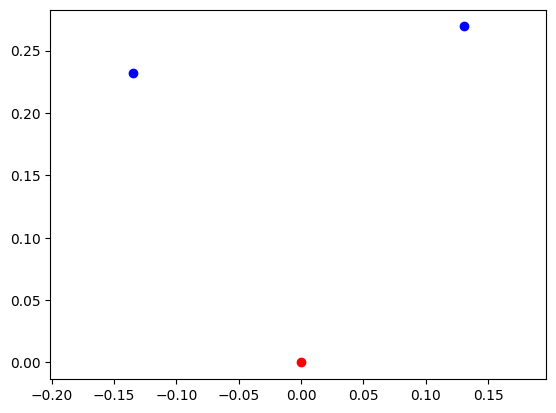

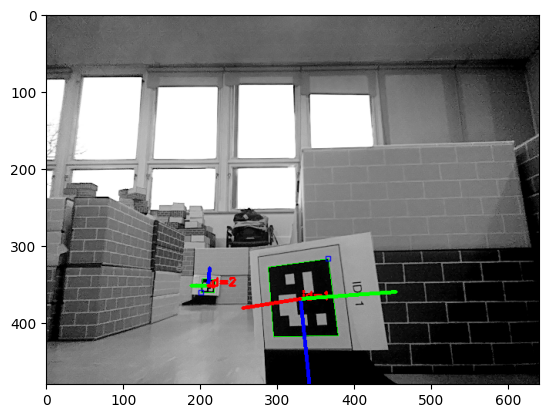

Frame 2 has 1 markers


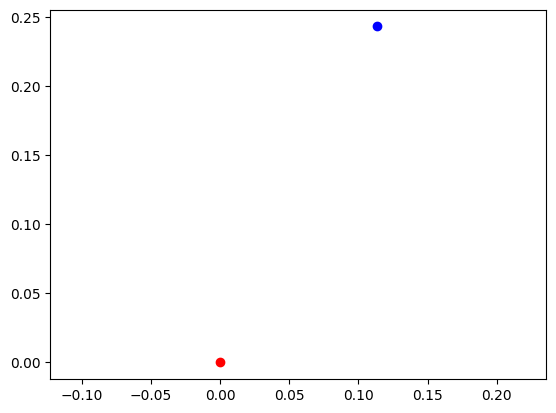

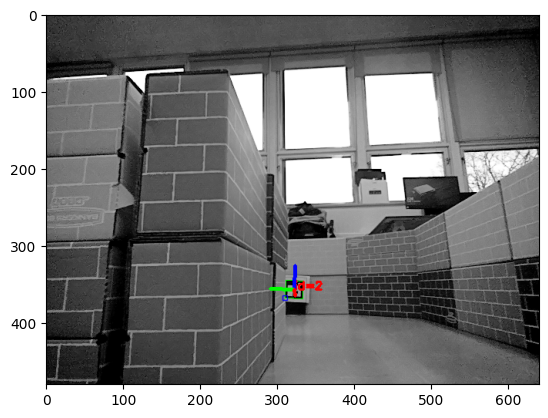

Frame 3 has 1 markers


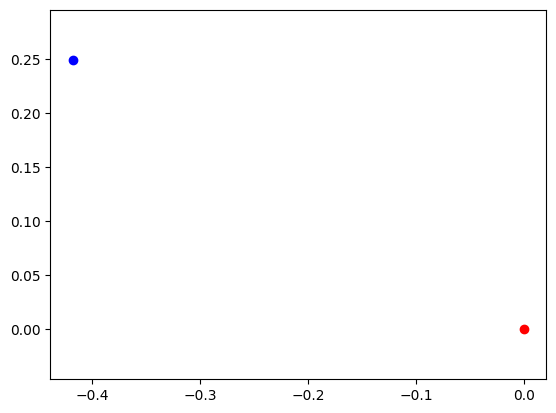

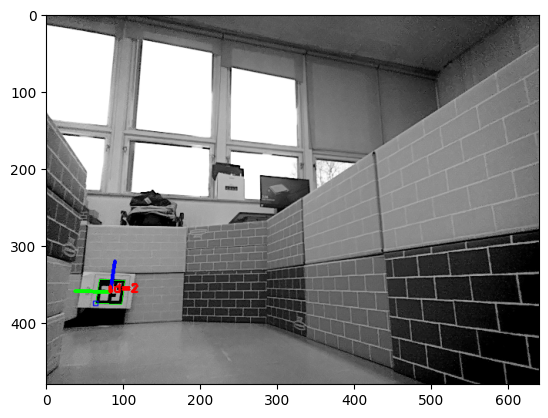

Frame 5 has 1 markers


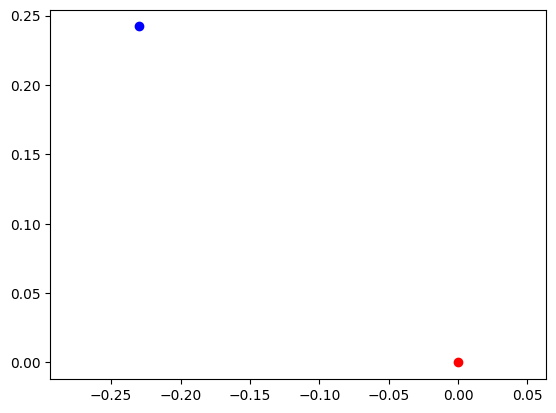

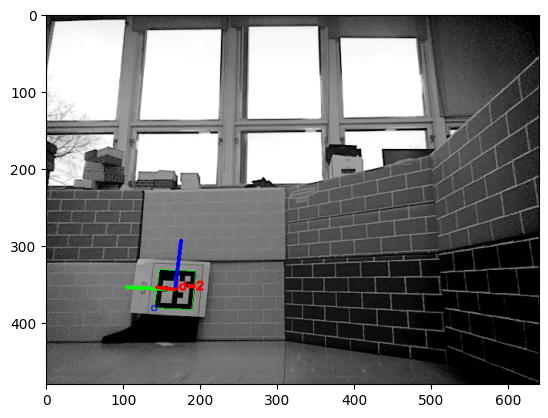

Frame 6 has 1 markers


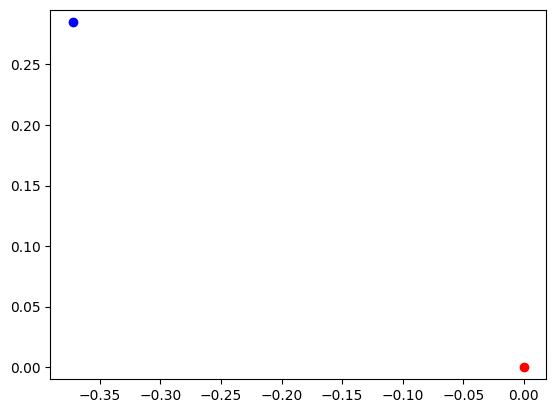

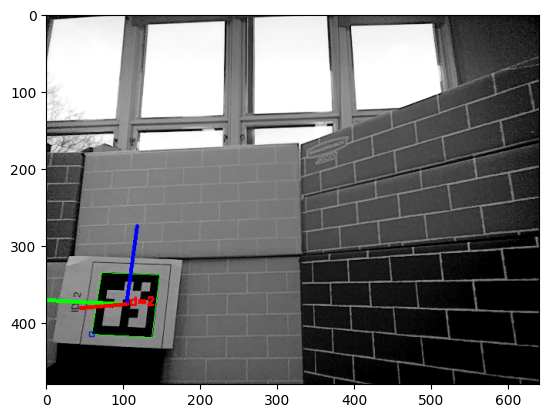

Frame 17 has 1 markers


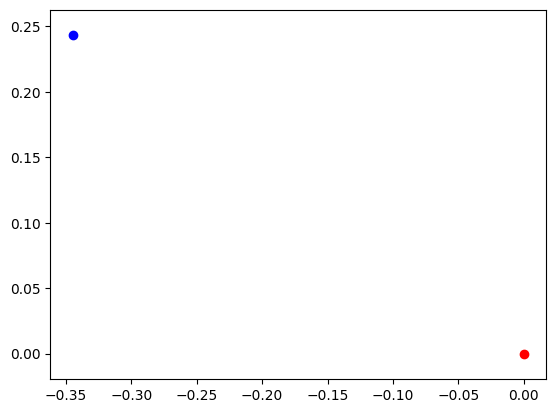

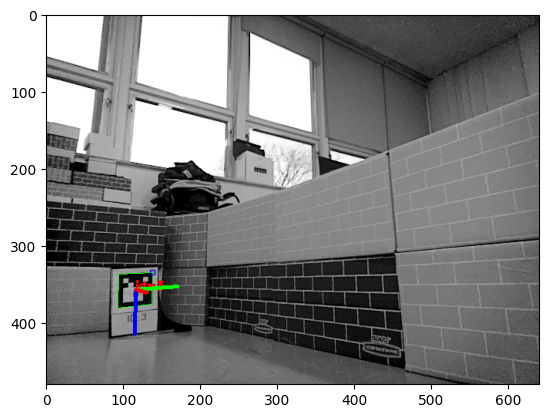

Frame 18 has 1 markers


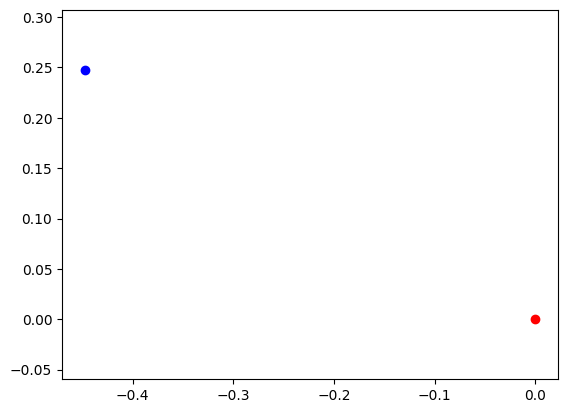

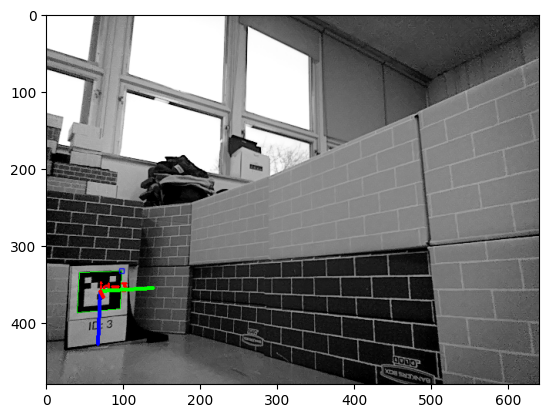

Frame 19 has 1 markers


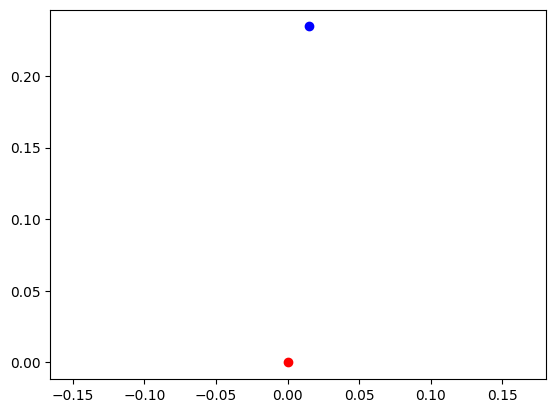

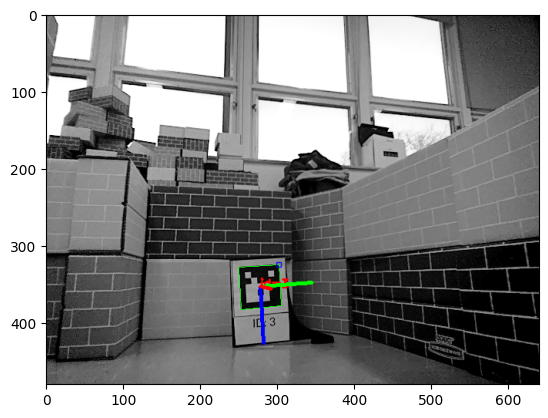

Frame 20 has 1 markers


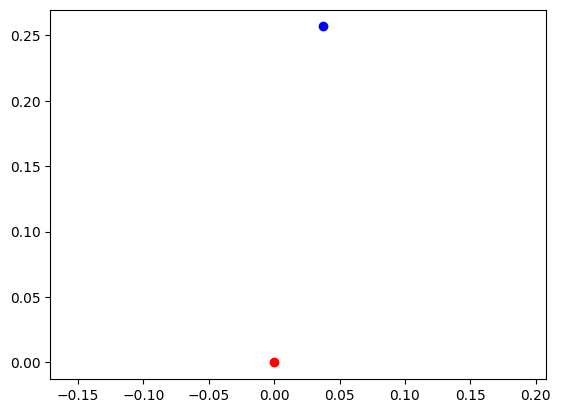

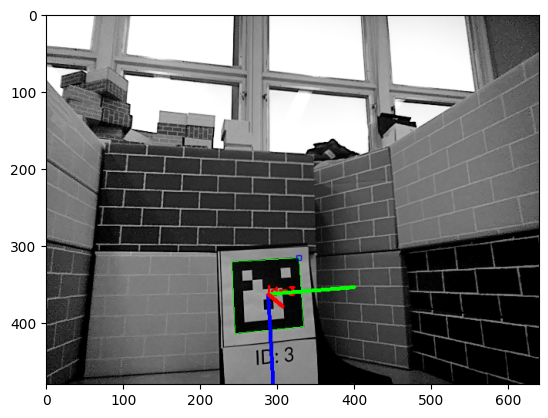

Frame 37 has 1 markers


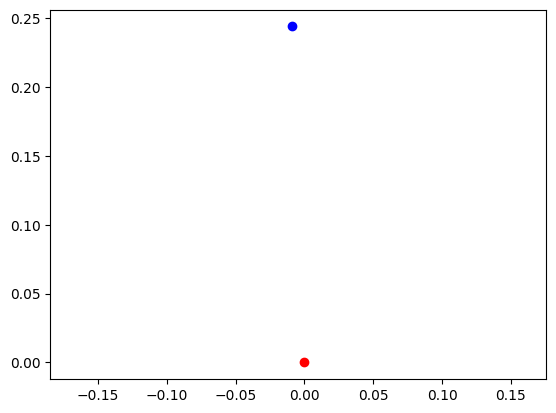

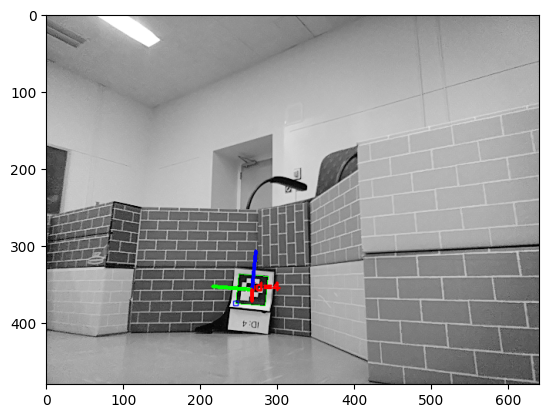

Frame 38 has 1 markers


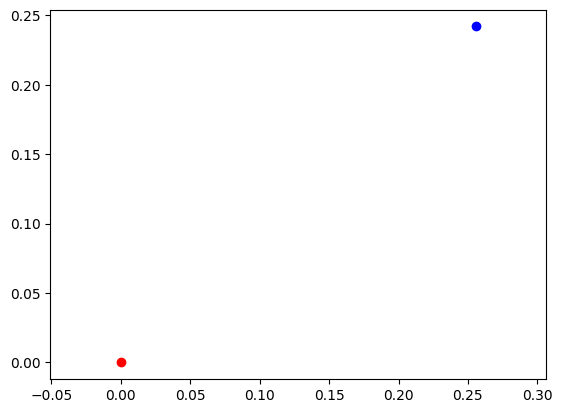

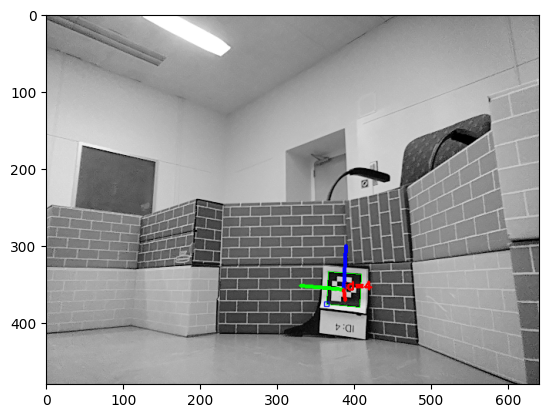

Frame 39 has 1 markers


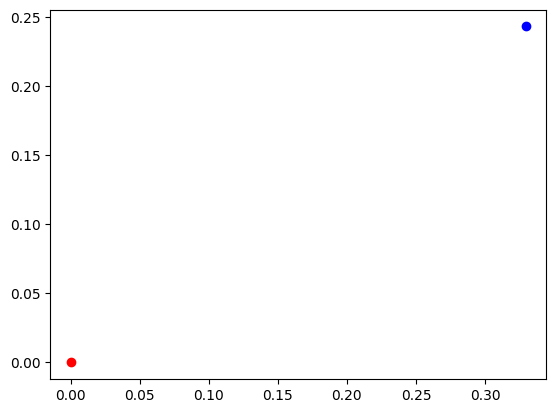

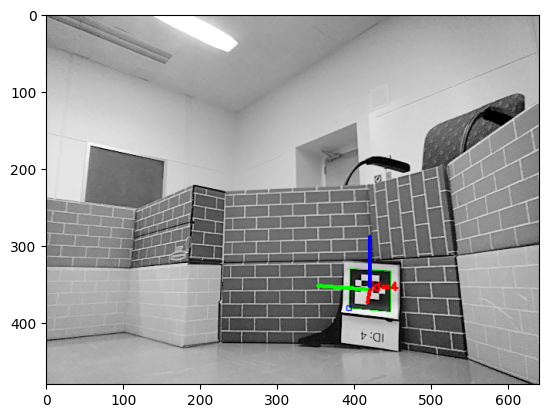

Frame 40 has 1 markers


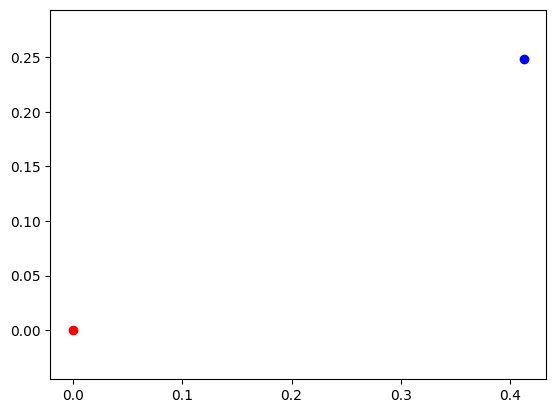

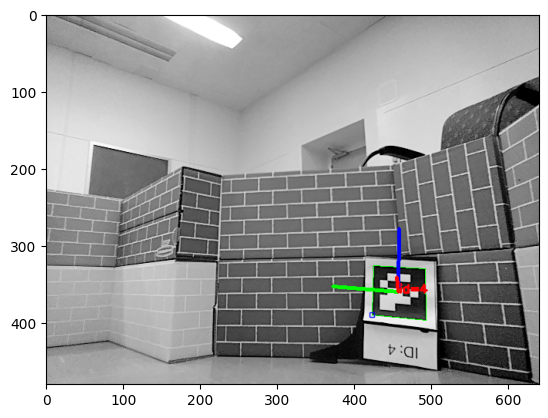

In [10]:
images = load_images()
detector = initArucoDetector()
arucos_tf_by_id = defaultdict(list)
for i, frame in enumerate(images):
    img = frame['data']
    corners, ids, _ = detector.detectMarkers(img)
    if ids is not None:
        print(f"Frame {i} has {len(ids)} markers")
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        rvecs, tvecs = estimateMarkerPose(corners, MARKER_SIZE, MATRICE_CAMERA, MATRICE_DISTORTION_CAMERA)
        img_with_markers = display_markers(img_color, corners, ids, MATRICE_CAMERA, MATRICE_DISTORTION_CAMERA, rvecs,
                                           tvecs)
        for j, marker_id in enumerate(ids):
            # Build the transformation matrix
            R = cv2.Rodrigues(rvecs[j])[0]
            t = np.array(tvecs[j])
            T = np.hstack((R, t))
            T = np.vstack((T, np.array([0, 0, 0, 1])))
            arucos_tf_by_id[marker_id[0]].append(T)
        plot_position_marker(tvecs, np.eye(3))
        # Create the directory if it does not exist
        cwd = os.getcwd()
        marker_path = pathlib.Path(cwd + '/figs/marker/')
        marker_path.mkdir(parents=True, exist_ok=True)
        # Save the image with markers
        cv2.imwrite(marker_path / (str(i) + '.png'), img_with_markers)
        # Plot the image with matplotlib
        plt.imshow(img_with_markers)
        plt.show()


## Question 1.2 - Recalage de deux nuages de points

Maintenant que nous pouvons détecter des marqueurs dans le référentiel du robot, il est temps d'estimer les déplacements du robot en utilisant l'algorithm ICP.

La fonction suivante permet de charger les données LiDAR.

In [11]:
def load_lidars() -> [dict]:
    """
    Load the lidar data from the data/lidar folder.
    :return: a list of dictionaries containing the lidar data.
             Each dictionary has the following keys ['angle_min', 'angle_max', 'angle_increment', 'range_min', 'range_max', 'ranges', 'timestamp']
    """
    paths = sorted(pathlib.Path('data/lidar').glob('*.pkl'))
    data = []
    for path in paths:
        with open(path, 'rb') as f:
            data.append(pickle.load(f))
    return data

In [12]:
scans = load_lidars()
print(scans[0].keys())

dict_keys(['angle_min', 'angle_max', 'angle_increment', 'range_min', 'range_max', 'ranges', 'timestamp'])


À partir de ces scans, complétez la fonction suivante pour générer des objets de type `PointCloud`.

In [13]:
def scan_to_point_cloud(scan: dict) -> PointCloud:
    """
    Convert a lidar scan to a point cloud.
    :param scan: a dictionary containing the lidar data.
    :return: a PointCloud object.
    """
    # TODO Convertir les valeurs de range en coordonnées cartésiennes
    angle_min = scan['angle_min']
    angle_max = scan['angle_max']
    angle_increment = scan['angle_increment']
    ranges = np.array(scan['ranges'], dtype=np.float32)
    angles = np.arange(angle_min, angle_max, angle_increment)[:len(ranges)]
    ranges = ranges[:(min(len(ranges), len(angles)))]
    
    x = ranges * np.cos(angles)
    y = ranges * np.sin(angles)
    
    valid = (ranges > scan['range_min']) & (ranges < scan['range_max'])
    x, y = x[valid], y[valid]
    
    # Assemblage des coordonnées en une matrice (2, n)
    pts = np.vstack((x, y))
    
    # TODO Enlever les points à l'origine

    # Les points devraient être de format (2, n) où n est le nombre de points
    assert pts.shape[0] == 2 and pts.shape[1] > 0
    return PointCloud.from_cartesian_scan(pts)


In [14]:
reading = scan_to_point_cloud(scans[0])
print('Points in homogeneous coordinates:', reading.features.shape)

Points in homogeneous coordinates: (3, 460)


Pour faire le recalage de nuages de points, on vous fournit la classe `r2_lidar_icp.icp.ICP`.
On initialise ici l'objet avec des valeurs par défaut.
Vous pouvez optionnellement modifier ces paramètres pour améliorer la qualité du recalage.

In [15]:
# Simule un LiDAR avec une portée entre 0.15 et 1.15m
radii_filter = RadiiFilter(0.15, 1.15)
# TODO (Optionnel) Vous pouvez ajuster ces paramètres
weight_function = lambda d: np.exp(-(d / 0.25) ** 2.0)
icp = (ICPBuilder()
       .with_minimizer(PointToPlaneMinimizer(weight_function=weight_function))
       .with_match_filter(MaxDistanceMatchFilter(0.5))
       .with_transformation_checker(MaxIterationTransformationChecker(100))
       .with_reading_preprocessing(radii_filter)
       .with_reference_preprocessing(radii_filter).build())

# La fonction icp.find_transformation(reading, reference, init_pose=initial_pose) permet de trouver la transformation entre reading et reference
# reading est le nuage de points à recaler et reference est le nuage de point qui reste fixe
# La fonction retourne une matrice de transformation homogène pour transformer reading dans le référentiel de reference

Pour faciliter la suite du devoir, on définit la fonction `rigid_transformation(x, y, theta)` qui construit une matrice de transformation homogène.

In [16]:
def rigid_transformation(x, y, theta):
    """
    Returns a rigid transformation matrix
    """
    # TODO Créer une matrice de transformation homogène faisant une translation de (x, y) et une rotation de theta
    theta = np.deg2rad(theta)
    MATRICE_TRANSFORMATION = np.array([
        [np.cos(theta), -np.sin(theta), x,],
        [np.sin(theta), np.cos(theta), y],
        [0.0, 0.0, 1.0]
    ])
    return MATRICE_TRANSFORMATION  # TODO


Nous allons maintenant procéder au recalage de deux nuages de points ensemble.

/tmp/ipykernel_179968/2595133819.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


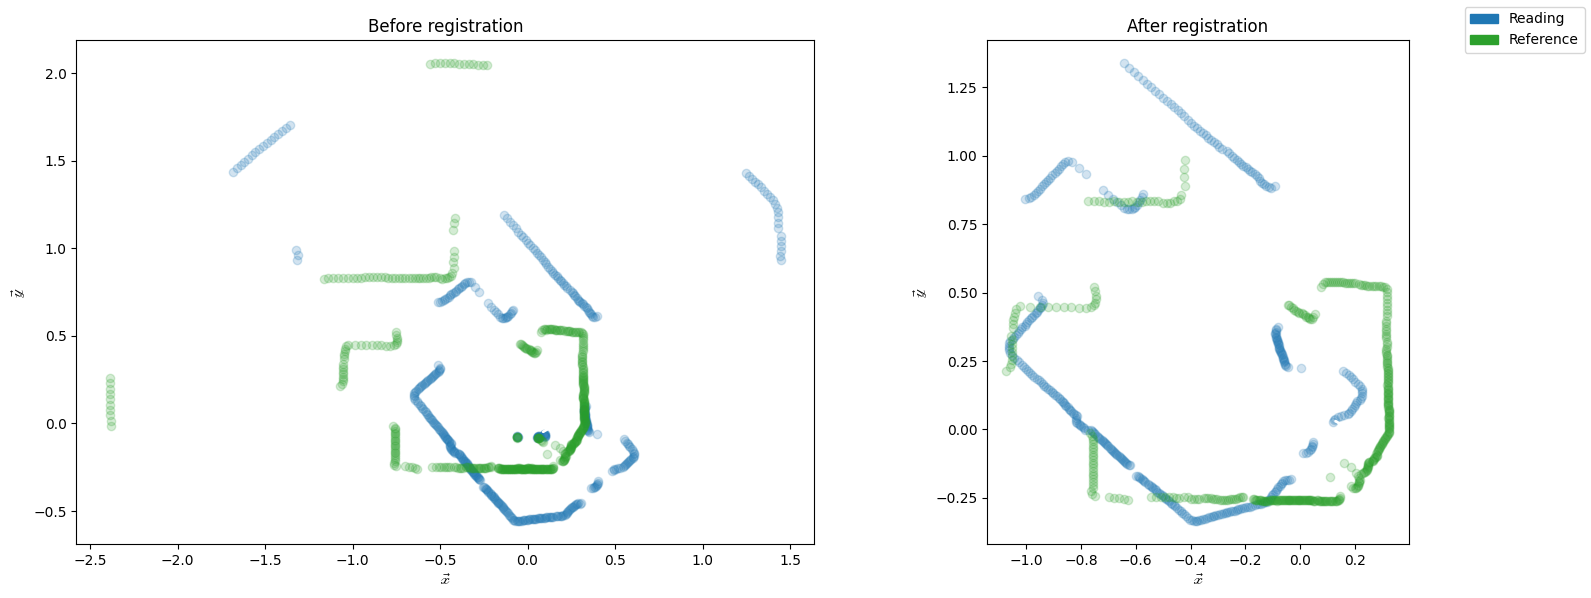

In [17]:
reference, reading = scan_to_point_cloud(scans[0]), scan_to_point_cloud(scans[1])

# Before registration
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
ax = axs[0]
ax.set_title('Before registration')
draw_point_clouds(ax, pc=reading.features, reference=reference.features)

# With registration
# TODO Trouver la transformation T qui permet de recaler reading sur reference
T = icp.find_transformation(reading, reference, init_pose=rigid_transformation(0, 0, 0)) # TODO
ax = axs[1]
ax.set_title('After registration')
# TODO Modifier la ligne suivante pour afficher les nuages de points ARPÈS recalage
draw_point_clouds(ax, pc=T @ reading.features, reference=reference.features) # TODO

fig.tight_layout()
fig.legend(
    handles=[mpatches.Patch(color='tab:blue', label='Reading'), mpatches.Patch(color='tab:green', label='Reference')])
fig.show()

**N.B. Vous devriez remarquer que le recalage a échoué. Voici quelques questions à répondre directement dans ce document.**

### Questions

#### Quelle faiblesse de l'algorithme ICP pourrait être la cause de l'échec du recalage?

TODO : La faibless de l'algorithme qui pourrait être la cause de l'échec du recalage est sa sensibilité aux extrema locaux (si le plus proche voisin n'est pas le bon point le recalage ne se fait pas correctement).

Pour remédier à la situation, nous allons fournir une transformation initiale à l'algorithme.
Essayez quelques transformations afin de trouver une transformation `T` qui recale bien les nuages de points.

[[ 0.65605903 -0.75470958 -0.22      ]
 [ 0.75470958  0.65605903  0.17      ]
 [ 0.          0.          1.        ]]
[[ 0.64249716 -0.76628806 -0.20905775]
 [ 0.76628806  0.64249716  0.16130399]
 [ 0.          0.          1.        ]]


/tmp/ipykernel_179968/1129409539.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


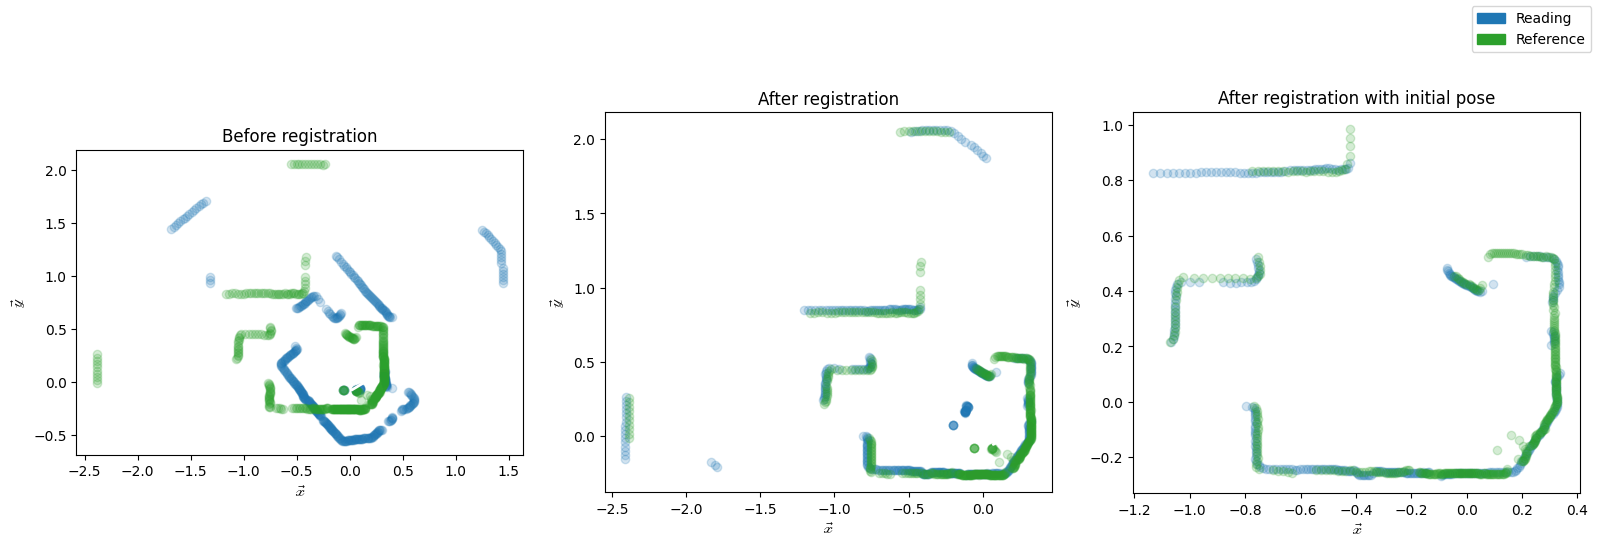

In [18]:

reference, reading = scan_to_point_cloud(scans[0]), scan_to_point_cloud(scans[1])

# Before registration
fig, axs = plt.subplots(ncols=3, figsize=(16, 6))
ax = axs[0]
ax.set_title('Before registration')
draw_point_clouds(ax, pc=reading.features, reference=reference.features)

# With registration
# TODO Trouver la transformation T qui permet de recaler reading sur reference
T = rigid_transformation(-0.22, 0.17, 49) # TODO
print(T)
ax = axs[1]
ax.set_title('After registration')
# TODO Modifier la ligne suivante pour afficher les nuages de points APRÈS recalage
draw_point_clouds(ax, pc=T @ reading.features, reference=reference.features) # TODO

# With registration and initial pose
# TODO Définir une transformation initiale qui permet au recalage de fonctionner
init_pose = rigid_transformation(-0.2, 0.12, 39) # TODO
# TODO Trouver la transformation T qui permet de recaler reading sur reference
T = icp.find_transformation(reading, reference, init_pose=init_pose) # TODO
print(T)
ax = axs[2]
ax.set_title('After registration with initial pose')
# TODO Modifier la ligne suivante pour afficher les nuages de points APRÈS recalage
draw_point_clouds(ax, pc=T @ reading.features, reference=reference.features) # TODO

fig.tight_layout()
fig.legend(
    handles=[mpatches.Patch(color='tab:blue', label='Reading'), mpatches.Patch(color='tab:green', label='Reference')])
fig.show()

### Questions
#### Ici, on a trouvé une transformation initale par une méthode d'essai-erreur. Comment pourrait-on obtenir un estimé de cette transformation à l'aide de capteurs ? En d'autres mots, quels capteurs étudiés lors des laboratoires du cours pourraient permettre d'estimer cette transformation?
TODO : On pourrait utiliser un Sonar pour permettre cet estimé.


## Question 1.3 - Cartographie

Maintenant que nous pouvons recaler des paires de nuages de points, nous allons construire une carte globale en recalant tous les nuages de points ensemble.

**N.B. _On n'utilise que les 30 premiers scans (de `lidar_00000.pkl` à `lidar_00029.pkl`) pour cette partie._**

Pour vous aider à déboguer le code, on génère des figures pour chaque itération de l'algorithme dans les dossiers `figs/pairs` et `figs/map`.


In [19]:
# Create the figures folder
figures_path = pathlib.Path('figs')
figures_pair_path = figures_path / 'pairs'
figures_map_path = figures_path / 'map'

figures_pair_path.mkdir(exist_ok=True, parents=True)
figures_map_path.mkdir(exist_ok=True, parents=True)

Voici la boucle pour la construction de la boucle. Assurez-vous de bien lire les commentaires dans le code pour comprendre le processus.

In [20]:
# TODO Comme pour la question 1.2, le recalage à certaines itérations va échouer. Pour ces itérations ajoutez des entrées dans le dictionnaire
# Le format est numero_iter: rigid_transformation(x, y, theta) pour appliquer la transformation à l'itération numero_iter
initial_poses_per_iteration = {
    0: rigid_transformation(-0.2, 0.12, 39),
    1: rigid_transformation(-0.2, 0.12, 39),
    2: rigid_transformation(-0.2, 0.12, 39),
    3: rigid_transformation(-0.2, 0.12, 39),
    4: rigid_transformation(-0.2, 0.12, 39),
    5: rigid_transformation(-0.2, 0.12, 39),
    6: rigid_transformation(-0.2, 0.12, 39),
    7: rigid_transformation(-0.2, 0.12, 39),
    8: rigid_transformation(-0.2, 0.12, 39),
    9: rigid_transformation(-0.2, 0.12, 39),
    10: rigid_transformation(-0.2, 0.12, 39),
    11: rigid_transformation(-0.2, 0.12, 39),
    12: rigid_transformation(-0.2, 0.12, 39),
    13: rigid_transformation(-0.2, 0.12, 39),
    14: rigid_transformation(-0.2, 0.12, 39),
    15: rigid_transformation(-0.2, 0.12, 39),
    16: rigid_transformation(-0.2, 0.12, 39),
    17: rigid_transformation(-0.2, 0.12, 39),
    18: rigid_transformation(-0.2, 0.12, 39),
    19: rigid_transformation(-0.2, 0.12, 39),
    20: rigid_transformation(-0.2, 0.12, 39),
    21: rigid_transformation(-0.2, 0.12, 39),
    22: rigid_transformation(-0.2, 0.12, 39),
    23: rigid_transformation(-0.2, 0.12, 39),
    24: rigid_transformation(-0.2, 0.12, 39),
    25: rigid_transformation(-0.2, 0.12, 39),
    26: rigid_transformation(-0.2, 0.12, 39),
    27: rigid_transformation(-0.2, 0.12, 39),
    28: rigid_transformation(-0.2, 0.12, 39),
    29: rigid_transformation(-0.2, 0.12, 39),
    30: rigid_transformation(-0.2, 0.12, 39)
}


# Variable gardant la transformation totale du robot
cumulative_T = np.eye(3)
# Liste des transformations
poses = [np.eye(3)]
# Carte contenant tous les points
global_map = scan_to_point_cloud(scans[0])

# On utilise seulement les 30 premiers scans
for i in tqdm(range(30)):
    reference = scan_to_point_cloud(scans[i])
    reading = scan_to_point_cloud(scans[i + 1])
    initial_pose = initial_poses_per_iteration.get(i, np.eye(3))

    # TODO Trouver la transformation entre reading et reference
    T = icp.find_transformation(reading, reference, init_pose=initial_pose) # TODO

    # TODO Accumuler les transformations dans cumulative_T
    cumulative_T = cumulative_T @ T # TODO
    poses.append(cumulative_T)
    print(f"Iteration {i}: Transformation T\n{T}")
    print(f"Iteration {i}: Transformation cum_T\n{cumulative_T}")
    global_map.features = np.hstack((global_map.features, cumulative_T @ reading.features))

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax = axs[0]
    ax.set_title(f'Before registration at iteration {i}')
    draw_point_clouds(ax, pc=reading.features, reference=reference.features)

    ax = axs[1]
    ax.set_title(f'After registration at iteration {i}')
    draw_point_clouds(ax, pc=cumulative_T @ reading.features, reference=reference.features)

    fig.tight_layout()
    fig.savefig(figures_pair_path / f'{i}.png')
    plt.close(fig)


    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f'Global map at iteration {i}')
    draw_point_clouds(ax, pc=global_map.features)
    fig.savefig(figures_map_path / f'{i}.png')
    plt.close(fig)


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 0: Transformation T
[[ 0.64249716 -0.76628806 -0.20905775]
 [ 0.76628806  0.64249716  0.16130399]
 [ 0.          0.          1.        ]]
Iteration 0: Transformation cum_T
[[ 0.64249716 -0.76628806 -0.20905775]
 [ 0.76628806  0.64249716  0.16130399]
 [ 0.          0.          1.        ]]


  3%|▎         | 1/30 [00:01<00:41,  1.42s/it]

Iteration 1: Transformation T
[[ 0.6479965  -0.76164331 -0.12551918]
 [ 0.76164331  0.6479965   0.20158841]
 [ 0.          0.          1.        ]]
Iteration 1: Transformation cum_T
[[-0.16730226 -0.98590565 -0.44417826]
 [ 0.98590565 -0.16730226  0.19464012]
 [ 0.          0.          1.        ]]


  7%|▋         | 2/30 [00:02<00:34,  1.24s/it]

Iteration 2: Transformation T
[[ 0.92052339  0.39068745  0.06552804]
 [-0.39068745  0.92052339  0.21864503]
 [ 0.          0.          1.        ]]
Iteration 2: Transformation cum_T
[[ 0.23117531 -0.97291211 -0.67070462]
 [ 0.97291211  0.23117531  0.22266478]
 [ 0.          0.          1.        ]]


 10%|█         | 3/30 [00:03<00:32,  1.19s/it]

Iteration 3: Transformation T
[[ 0.38558647  0.9226717  -0.60924676]
 [-0.9226717   0.38558647  0.02555393]
 [ 0.          0.          1.        ]]
Iteration 3: Transformation cum_T
[[ 0.98681655 -0.16184283 -0.83640916]
 [ 0.16184283  0.98681655 -0.36417133]
 [ 0.          0.          1.        ]]


 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]

Iteration 4: Transformation T
[[ 0.92889678 -0.37033872 -0.10233055]
 [ 0.37033872  0.92889678  0.25569072]
 [ 0.          0.          1.        ]]
Iteration 4: Transformation cum_T
[[ 0.85671405 -0.51579166 -0.97877235]
 [ 0.51579166  0.85671405 -0.12841297]
 [ 0.          0.          1.        ]]


 17%|█▋        | 5/30 [00:06<00:29,  1.20s/it]

Iteration 5: Transformation T
[[ 9.99488834e-01 -3.19698300e-02 -9.59180232e-04]
 [ 3.19698300e-02  9.99488834e-01  2.72644832e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Iteration 5: Transformation cum_T
[[ 0.83978636 -0.542917   -1.12022202]
 [ 0.542917    0.83978636  0.10467096]
 [ 0.          0.          1.        ]]


 20%|██        | 6/30 [00:07<00:29,  1.24s/it]

Iteration 6: Transformation T
[[ 0.6938506  -0.72011898 -0.11017276]
 [ 0.72011898  0.6938506   0.06347069]
 [ 0.          0.          1.        ]]
Iteration 6: Transformation cum_T
[[ 0.19172143 -0.98144938 -1.24720292]
 [ 0.98144938  0.19172143  0.09815812]
 [ 0.          0.          1.        ]]


 23%|██▎       | 7/30 [00:08<00:29,  1.27s/it]

Iteration 7: Transformation T
[[ 0.80929884 -0.58739713 -0.02952827]
 [ 0.58739713  0.80929884  0.12682199]
 [ 0.          0.          1.        ]]
Iteration 7: Transformation cum_T
[[-0.42134062 -0.90690247 -1.37733349]
 [ 0.90690247 -0.42134062  0.09349211]
 [ 0.          0.          1.        ]]


 27%|██▋       | 8/30 [00:10<00:28,  1.29s/it]

Iteration 8: Transformation T
[[ 0.76328619 -0.64606052 -0.15081659]
 [ 0.64606052  0.76328619  0.1713766 ]
 [ 0.          0.          1.        ]]
Iteration 8: Transformation cum_T
[[-0.90751735 -0.42001459 -1.4692102 ]
 [ 0.42001459 -0.90751735 -0.11549175]
 [ 0.          0.          1.        ]]


 30%|███       | 9/30 [00:11<00:27,  1.33s/it]

Iteration 9: Transformation T
[[ 0.99906014 -0.04334558 -0.01082294]
 [ 0.04334558  0.99906014  0.25657933]
 [ 0.          0.          1.        ]]
Iteration 9: Transformation cum_T
[[-0.92487019 -0.38028297 -1.56715526]
 [ 0.38028297 -0.92487019 -0.35288773]
 [ 0.          0.          1.        ]]


 33%|███▎      | 10/30 [00:12<00:27,  1.37s/it]

Iteration 10: Transformation T
[[ 0.99960044 -0.02826585 -0.00280995]
 [ 0.02826585  0.99960044  0.25584967]
 [ 0.          0.          1.        ]]
Iteration 10: Transformation cum_T
[[-0.93524967 -0.35398878 -1.66185169]
 [ 0.35398878 -0.93524967 -0.59058404]
 [ 0.          0.          1.        ]]


 37%|███▋      | 11/30 [00:14<00:25,  1.37s/it]

Iteration 11: Transformation T
[[ 0.43947351 -0.89825555 -0.03984151]
 [ 0.89825555  0.43947351 -0.32050257]
 [ 0.          0.          1.        ]]
Iteration 11: Transformation cum_T
[[-0.72898984  0.68452452 -1.51113562]
 [-0.68452452 -0.72898984 -0.30493756]
 [ 0.          0.          1.        ]]


 40%|████      | 12/30 [00:15<00:24,  1.37s/it]

Iteration 12: Transformation T
[[ 0.78064264 -0.62497766 -0.25257203]
 [ 0.62497766  0.78064264  0.09415782]
 [ 0.          0.          1.        ]]
Iteration 12: Transformation cum_T
[[-0.14126803  0.98997139 -1.26255985]
 [-0.98997139 -0.14126803 -0.2006859 ]
 [ 0.          0.          1.        ]]


 43%|████▎     | 13/30 [00:16<00:22,  1.33s/it]

Iteration 13: Transformation T
[[ 0.98041007  0.19696725  0.05418971]
 [-0.19696725  0.98041007  0.22587851]
 [ 0.          0.          1.        ]]
Iteration 13: Transformation cum_T
[[-0.33349254  0.94275274 -1.04660186]
 [-0.94275274 -0.33349254 -0.28624158]
 [ 0.          0.          1.        ]]


 47%|████▋     | 14/30 [00:18<00:21,  1.36s/it]

Iteration 14: Transformation T
[[ 0.93575005  0.35266393  0.11291409]
 [-0.35266393  0.93575005  0.23272141]
 [ 0.          0.          1.        ]]
Iteration 14: Transformation cum_T
[[-0.64454055  0.76457013 -0.86485913]
 [-0.76457013 -0.64454055 -0.4703025 ]
 [ 0.          0.          1.        ]]


 50%|█████     | 15/30 [00:19<00:20,  1.38s/it]

Iteration 15: Transformation T
[[ 0.8696686   0.49363602  0.024212  ]
 [-0.49363602  0.8696686  -0.00148623]
 [ 0.          0.          1.        ]]
Iteration 15: Transformation cum_T
[[-0.93795603  0.34675421 -0.88160108]
 [-0.34675421 -0.93795603 -0.48785633]
 [ 0.          0.          1.        ]]


 53%|█████▎    | 16/30 [00:21<00:19,  1.39s/it]

Iteration 16: Transformation T
[[ 0.72523087 -0.68850577  0.06869301]
 [ 0.68850577  0.72523087 -0.1164321 ]
 [ 0.          0.          1.        ]]
Iteration 16: Transformation cum_T
[[-0.44149239  0.89726499 -0.98640542]
 [-0.89726499 -0.44149239 -0.40246774]
 [ 0.          0.          1.        ]]


 57%|█████▋    | 17/30 [00:22<00:18,  1.40s/it]

Iteration 17: Transformation T
[[ 0.99991729  0.01286112  0.00470245]
 [-0.01286112  0.99991729  0.12253311]
 [ 0.          0.          1.        ]]
Iteration 17: Transformation cum_T
[[-0.45299571  0.8915127  -0.87853684]
 [-0.8915127  -0.45299571 -0.46078452]
 [ 0.          0.          1.        ]]


 60%|██████    | 18/30 [00:24<00:17,  1.45s/it]

Iteration 18: Transformation T
[[ 0.92989877 -0.36781555 -0.05774014]
 [ 0.36781555  0.92989877  0.13229288]
 [ 0.          0.          1.        ]]
Iteration 18: Transformation cum_T
[[-0.09332791  0.99563543 -0.73444003]
 [-0.99563543 -0.09332791 -0.46923656]
 [ 0.          0.          1.        ]]


 63%|██████▎   | 19/30 [00:25<00:15,  1.40s/it]

Iteration 19: Transformation T
[[ 0.89287859  0.45029748 -0.40199444]
 [-0.45029748  0.89287859  0.19947382]
 [ 0.          0.          1.        ]]
Iteration 19: Transformation cum_T
[[-0.53166262  0.84695623 -0.49831952]
 [-0.84695623 -0.53166262 -0.08761313]
 [ 0.          0.          1.        ]]


 67%|██████▋   | 20/30 [00:26<00:13,  1.39s/it]

Iteration 20: Transformation T
[[ 0.82163846 -0.57000898 -0.06629047]
 [ 0.57000898  0.82163846  0.13417552]
 [ 0.          0.          1.        ]]
Iteration 20: Transformation cum_T
[[ 0.0459382   0.99894428 -0.34943457]
 [-0.99894428  0.0459382  -0.10280411]
 [ 0.          0.          1.        ]]


 70%|███████   | 21/30 [00:28<00:12,  1.38s/it]

Iteration 21: Transformation T
[[ 0.98247782 -0.18637952 -0.02430492]
 [ 0.18637952  0.98247782  0.09341031]
 [ 0.          0.          1.        ]]
Iteration 21: Transformation cum_T
[[ 0.23131602  0.97287867 -0.2572394 ]
 [-0.97287867  0.23131602 -0.07423375]
 [ 0.          0.          1.        ]]


 73%|███████▎  | 22/30 [00:29<00:11,  1.39s/it]

Iteration 22: Transformation T
[[ 0.71875112 -0.69526745 -0.10583586]
 [ 0.69526745  0.71875112  0.06228908]
 [ 0.          0.          1.        ]]
Iteration 22: Transformation cum_T
[[ 0.84266951  0.53843114 -0.22112121]
 [-0.53843114  0.84266951  0.04314016]
 [ 0.          0.          1.        ]]


 77%|███████▋  | 23/30 [00:30<00:09,  1.39s/it]

Iteration 23: Transformation T
[[ 0.99362552 -0.11273125 -0.35935049]
 [ 0.11273125  0.99362552  0.18376928]
 [ 0.          0.          1.        ]]
Iteration 23: Transformation cum_T
[[ 0.89799595  0.44000373 -0.42498782]
 [-0.44000373  0.89799595  0.39148243]
 [ 0.          0.          1.        ]]


 80%|████████  | 24/30 [00:32<00:08,  1.41s/it]

Iteration 24: Transformation T
[[ 0.99999805  0.00197232  0.0039174 ]
 [-0.00197232  0.99999805  0.12933899]
 [ 0.          0.          1.        ]]
Iteration 24: Transformation cum_T
[[ 0.89712637  0.44177401 -0.36456038]
 [-0.44177401  0.89712637  0.50590465]
 [ 0.          0.          1.        ]]


 83%|████████▎ | 25/30 [00:33<00:07,  1.41s/it]

Iteration 25: Transformation T
[[ 0.66240972 -0.74914175 -0.13766063]
 [ 0.74914175  0.66240972  0.1914407 ]
 [ 0.          0.          1.        ]]
Iteration 25: Transformation cum_T
[[ 0.92521658 -0.37943943 -0.40348583]
 [ 0.37943943  0.92521658  0.73846603]
 [ 0.          0.          1.        ]]


 87%|████████▋ | 26/30 [00:35<00:05,  1.42s/it]

Iteration 26: Transformation T
[[ 0.99937746 -0.03528009 -0.00694095]
 [ 0.03528009  0.99937746  0.13854339]
 [ 0.          0.          1.        ]]
Iteration 26: Transformation cum_T
[[ 0.91125394 -0.41184494 -0.46247654]
 [ 0.41184494  0.91125394  0.864015  ]
 [ 0.          0.          1.        ]]


 90%|█████████ | 27/30 [00:36<00:04,  1.37s/it]

Iteration 27: Transformation T
[[ 0.68653523 -0.72709654 -0.08613072]
 [ 0.72709654  0.68653523  0.07148442]
 [ 0.          0.          1.        ]]
Iteration 27: Transformation cum_T
[[ 0.32615691 -0.94531565 -0.57040399]
 [ 0.94531565  0.32615691  0.89368296]
 [ 0.          0.          1.        ]]


 93%|█████████▎| 28/30 [00:37<00:02,  1.37s/it]

Iteration 28: Transformation T
[[ 0.99811246 -0.06141261 -0.01119028]
 [ 0.06141261  0.99811246  0.25813195]
 [ 0.          0.          1.        ]]
Iteration 28: Transformation cum_T
[[ 0.26748697 -0.96356148 -0.81806995]
 [ 0.96356148  0.26748697  0.96729613]
 [ 0.          0.          1.        ]]


 97%|█████████▋| 29/30 [00:39<00:01,  1.37s/it]

Iteration 29: Transformation T
[[ 0.99961155 -0.02787006 -0.00286839]
 [ 0.02787006  0.99961155  0.25890302]
 [ 0.          0.          1.        ]]
Iteration 29: Transformation cum_T
[[ 0.24052855 -0.97064206 -1.06830618]
 [ 0.97064206  0.24052855  1.03378545]
 [ 0.          0.          1.        ]]


100%|██████████| 30/30 [00:40<00:00,  1.35s/it]


Inspectez les figures dans `figs` et ajustez les transformations initiale jusqu'à ce que la carte ressemble à la photo du parcours présenté dans l'énoncé.

On affiche ici la carte complète et les poses du robot.

/tmp/ipykernel_179968/3118557001.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


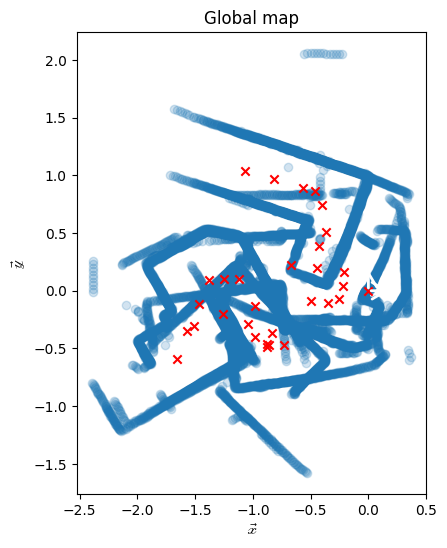

In [21]:
poses = np.array(poses)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Global map')
draw_point_clouds(ax, pc=global_map.features)
ax.scatter(poses[:, 0, 2], poses[:, 1, 2], c='r', marker='x', label='Robot poses')
fig.show()


### Effet corridor
Le parcours comporte un long corridor excédant la portée du LiDAR (qui est de 1.15m). Que ce passerait-t'il si le robot essayait de s'y localiser en utilisant seulement le LiDAR? Pour tester, essayez de construire une carte en utilisant les scans entre 28 et 40.

In [22]:
# Variable gardant la transformation totale du robot
cumulative_T = np.eye(3)
# Liste des transformations
poses = [np.eye(3)]
# Carte contenant tous les points
global_map = scan_to_point_cloud(scans[28])

for i in tqdm(range(28, 40)):
    reference = scan_to_point_cloud(scans[i])
    reading = scan_to_point_cloud(scans[i + 1])

    # TODO Trouver la transformation entre reading et reference sans pose initiale
    T = icp.find_transformation(reading, reference) # TODO

    # TODO Accumuler les transformations dans cumulative_T
    cumulative_T = cumulative_T @ T  # TODO
    poses.append(cumulative_T)

    global_map.features = np.hstack((global_map.features, cumulative_T @ reading.features))

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax = axs[0]
    ax.set_title(f'Before registration at iteration {i}')
    draw_point_clouds(ax, pc=reading.features, reference=reference.features)

    ax = axs[1]
    ax.set_title(f'After registration at iteration {i}')
    draw_point_clouds(ax, pc=cumulative_T @ reading.features, reference=reference.features)

    fig.tight_layout()
    fig.savefig(figures_pair_path / f'{i}.png')
    plt.close(fig)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f'Global map at iteration {i}')
    draw_point_clouds(ax, pc=global_map.features)
    fig.savefig(figures_map_path / f'{i}.png')
    plt.close(fig)


100%|██████████| 12/12 [00:18<00:00,  1.50s/it]


/tmp/ipykernel_179968/3118557001.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


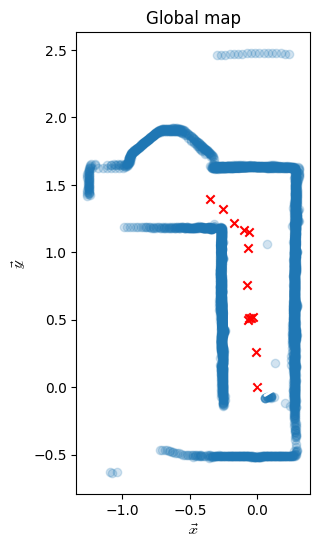

In [23]:
poses = np.array(poses)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Global map')
draw_point_clouds(ax, pc=global_map.features)
ax.scatter(poses[:, 0, 2], poses[:, 1, 2], c='r', marker='x', label='Robot poses')
fig.show()


### Questions
#### En comparant votre première carte et celle du corridor, que remarquez-vous ?

On remarque tout de suite que la carte essayent de se recaler en utilisant des positions initiales ne marche pas du tout aussi bien que la corridor. La carte corridor est quasiment parfaite.

#### Qu'est-ce qui cause ce problème ? Inspectez les figures dans `figs/pairs`. **[GLO-7021 seulement]**
TODO Votre réponse...

#### Comment pourriez-vous régler le problème ? **[GLO-7021 seulement]**
TODO Votre réponse...



## Question 1.4 - Localisation des marqueurs dans la carte globale




In [24]:
# TODO Réutiliser les valeurs de Q 1.3
initial_poses_per_iteration = {
    0: rigid_transformation(0, 0, 0),
    1: rigid_transformation(-0.05, 0.05, 10),
    2: rigid_transformation(-0.1, 0.1, 20),
    3: rigid_transformation(-0.15, 0.15, 30),
    4: rigid_transformation(-0.20, 0.20, 40),
    5: rigid_transformation(-0.25, 0.25, 50),
    6: rigid_transformation(-0.30, 0.30, 60)
}

# Variable gardant la transformation totale du robot
cumulative_T = np.eye(3)
# Liste des transformations
poses = [np.eye(3)]
# Carte contenant tous les points
global_map = scan_to_point_cloud(scans[0])
# Dictionnaire contenant la liste de position pour chaque ArUco
arucos_tf_by_id = defaultdict(list)

# On utilise seulement les 30 premiers scans
for i in tqdm(range(30)):
    reference = scan_to_point_cloud(scans[i])
    reading = scan_to_point_cloud(scans[i + 1])
    initial_pose = initial_poses_per_iteration.get(i, np.eye(3))
    img = images[i]['data']
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # TODO Trouver la position relative pour chaque marqueur ArUco et remplir arucos_tf_by_id
    corners, ids, _ = detector.detectMarkers(img)
    if ids is not None:
        rvecs, tvecs = estimateMarkerPose(corners, MARKER_SIZE, MATRICE_CAMERA, MATRICE_DISTORTION_CAMERA)
        for j, marker_id in enumerate(ids):
            # Construction de la matrice de transformation pour chaque marqueur
            R = cv2.Rodrigues(rvecs[j])[0]
            t = tvecs[j]
            T_marker = np.eye(3)
            T_marker[:2, :2] = R[:2, :2]
            T_marker[:2, 2] = t[:2].flatten()
            arucos_tf_by_id[marker_id[0]].append(T_marker)

    # TODO Trouver la transformation entre reading et reference
    T = icp.find_transformation(reading, reference, init_pose=rigid_transformation(0, 0, 0)) # TODO


    # TODO Accumuler les transformations dans cumulative_T
    cumulative_T = cumulative_T @ T
    poses.append(cumulative_T)

    global_map.features = np.hstack((global_map.features, cumulative_T @ reading.features))

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax = axs[0]
    ax.set_title(f'Before registration at iteration {i}')
    draw_point_clouds(ax, pc=reading.features, reference=reference.features)

    ax = axs[1]
    ax.set_title(f'After registration at iteration {i}')
    draw_point_clouds(ax, pc=cumulative_T @ reading.features, reference=reference.features)

    fig.tight_layout()
    fig.savefig(figures_pair_path / f'{i}.png')
    plt.close(fig)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f'Global map at iteration {i}')
    draw_point_clouds(ax, pc=global_map.features)
    fig.savefig(figures_map_path / f'{i}.png')
    plt.close(fig)


100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


/tmp/ipykernel_179968/4191202956.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


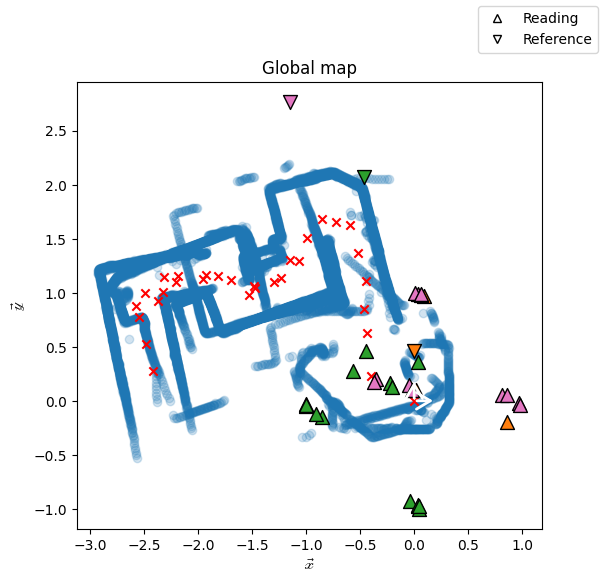

In [25]:
poses = np.array(poses)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Global map')
draw_point_clouds(ax, pc=global_map.features)
ax.scatter(poses[:, 0, 2], poses[:, 1, 2], c='r', marker='x', label='Robot poses')

colors = ['tab:orange', 'tab:green', 'tab:pink']
for i, (marker_id, marker_poses) in enumerate(arucos_tf_by_id.items()):
    marker_poses = np.array(marker_poses)
    plt.scatter(marker_poses[:, 0], marker_poses[:, 1], marker='^', s=100, color=colors[i], edgecolors='black')

# Vraie position des marqueurs
TILE_SIZE = 0.23
DICT_MARKER_POS = {1: (0, 2), 2: (-2, 9), 3: (-5, 12), 4: (-6, -2), 5: (-7, 3)}
for i in range(3):
    p = DICT_MARKER_POS[i + 1]
    plt.scatter(p[0] * TILE_SIZE, p[1] * TILE_SIZE, marker='v', s=100, color=colors[i], edgecolors='black')

# Add the legend to the figure
fig.legend(handles=[
    mlines.Line2D([], [], color='white', markeredgecolor='black', marker='^', linestyle='None', label='Reading'),
    mlines.Line2D([], [], color='white', markeredgecolor='black', marker='v', linestyle='None', label='Reference')])

fig.show()